In [1]:
%cd ..

c:\Users\danie\Documents\My Projects\sentiment-analysis-challenge


In [3]:
#check which GPU we got
!nvidia-smi

Thu Jun  9 11:04:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Libraries

In [4]:
!pip install transformers==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 563 kB 5.3 MB/s 
     |████████████████████████████████| 5.6 MB 35.5 MB/s 
     |████████████████████████████████| 132 kB 46.3 MB/s 
     |████████████████████████████████| 1.2 MB 57.2 MB/s 
     |████████████████████████████████| 880 kB 62.0 MB/s 
     |████████████████████████████████| 8.9 MB 49.8 MB/s 
     |████████████████████████████████| 79 kB 9.9 MB/s 
     |████████████████████████████████| 138 kB 77.1 MB/s 
     |████████████████████████████████| 127 kB 51.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=40dec0310ad701033d4d2a39ac2b20643fe9966f53bae101a3e207e515298abf
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    U

In [5]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import torch
import torch.nn as nn
from transformers import BertModel

import torch.nn.functional as F
from transformers import BertTokenizer
import pickle

from transformers import AdamW, get_linear_schedule_with_warmup

import random
import time

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC


%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Dataset

In [12]:

file_path = "data/cleaned_labelled_text.csv" #@param {type:"string"}
data=pd.read_csv(file_path ,encoding='latin-1')

# remove nan
data=data.dropna()
# sample only some of the data to make the training faster
n_sample= 40000 #@param{type:"integer"}
data=data.sample(n= n_sample, random_state=11) 

#encode the label to integers
le = preprocessing.LabelEncoder()
data['label']=le.fit_transform(data['sentiment'].values)
le_name_mapping = {le.classes_[i]: le.transform(le.classes_)[i] for i in range(len(le.classes_))}


tweets = data.tweet.values
labels = data.label.values


# train-val-test-split
train_ratio = 0.6 #@param{type:"number"}
validation_ratio = 0.2 #@param{type:"number"}
test_ratio = 0.2 #@param{type:"number"}


x_train, x_test, y_train, y_test = train_test_split(tweets, labels, test_size=1 - train_ratio, random_state=11)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=11)

print("Train data:{} tweets".format(len(y_train)))
print("Val data:{} tweets".format(len(y_val)))
print("Test data:{} tweets".format(len(y_test)))


print("Labels:")
print(le_name_mapping)

Train data:24000 tweets
Val data:8000 tweets
Test data:8000 tweets
Labels:
{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


## 3. Models 

### 3.1 Baseline: TF-IDF + SVM



#### Preprocessing




In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [13]:


def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s


# Preprocess text
x_train_preprocessed = np.array([text_preprocessing(text) for text in x_train])
x_test_preprocessed = np.array([text_preprocessing(text) for text in x_test])

#### Training




##### TF-IDF + SVM

In [14]:

# initiate model
cv=CountVectorizer(ngram_range=(1, 3), binary=True)
tfidf= TfidfTransformer(smooth_idf=False)
svc=SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)


components = [("vect", cv), 
        ("tfidf", tfidf),
        ("svm", svc)]
pipe = Pipeline(components)
pipe.fit(x_train_preprocessed,y_train )
# save model
filename = 'SVM.pkl'
model_dir = '/models/' #@param{type:"string"}
pickle.dump(pipe, open(model_dir+filename, 'wb'))

#### Evaluation on Test Dataset

In [38]:
#load model
model_path = 'models/SVM.pkl' #@param{type:"string"}
with open(model_path , 'rb') as f:
    model = pickle.load(f)
# predic test dataset
y_pred= model.predict(x_test_preprocessed)
print(classification_report(y_test, y_pred,target_names=list(le_name_mapping.keys())))

              precision    recall  f1-score   support

  Irrelevant       0.89      0.73      0.80      1377
    Negative       0.83      0.92      0.87      2497
     Neutral       0.87      0.80      0.83      1956
    Positive       0.82      0.87      0.84      2170

    accuracy                           0.84      8000
   macro avg       0.85      0.83      0.84      8000
weighted avg       0.85      0.84      0.84      8000



#### Inference

In [43]:
def svm_predict_text(model, text):
    config={
      "CLASS_NAMES": [
        'Irrelevant', 
        'Negative', 
        'Neutral', 
        'Positive'
      ]
    }
    preprocessed_text = text_preprocessing(text)
    probabilities = model.predict_proba([preprocessed_text])
    probabilities = torch.from_numpy(probabilities)
    confidence, predicted_class = torch.max(probabilities, dim=1)
    predicted_class = predicted_class.cpu().item()
    probabilities = probabilities.flatten().cpu().numpy().tolist()
    return (
            config["CLASS_NAMES"][predicted_class],
            confidence.cpu().numpy(),
            dict(zip(config["CLASS_NAMES"], probabilities)),
        )

In [44]:
#load model
model_path = 'models/SVM.pkl' #@param{type:"string"}
with open(model_path , 'rb') as f:
    model = pickle.load(f)

In [45]:
# predict 
text = "just played gta i think i should play other games"#@param{type:"string"}
svm_predict_text(model,text )

('Positive',
 array([0.96006976]),
 {'Irrelevant': 0.0046383965079831195,
  'Negative': 0.03509365974418417,
  'Neutral': 0.0001981832508759987,
  'Positive': 0.9600697604969568})

### 3.2 BERT

#### Setup

In [19]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


#### Preprocessing and Tokenization

Before tokenizing, we need to  check the distribution of the length of our sentences.

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

(array([2.4831e+04, 1.1828e+04, 3.1360e+03, 1.1300e+02, 1.9000e+01,
        3.9000e+01, 2.6000e+01, 5.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([  2. ,  33.3,  64.6,  95.9, 127.2, 158.5, 189.8, 221.1, 252.4,
        283.7, 315. ]),
 <a list of 10 Patch objects>)

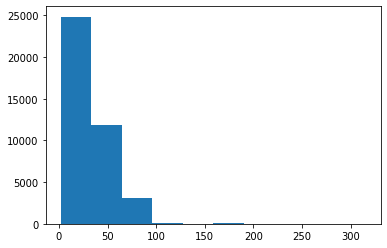

In [20]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Encode the tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in tweets]

# Find length distribution
lengths=[len(sent) for sent in encoded_tweets]
plt.hist(lengths)

In [21]:

# Specify `MAX_LEN`
MAX_LEN = 64 #@param {type:"integer"}






The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [22]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

#### Create Dataloader

In [23]:

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Run function `preprocessing_for_bert` on the train set and the validation set
train_inputs, train_masks = preprocessing_for_bert(x_train)
val_inputs, val_masks = preprocessing_for_bert(x_val)
test_inputs, test_masks = preprocessing_for_bert(x_test)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)


# Create the DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(val_data, sampler=test_sampler, batch_size=batch_size)

#### Training

##### Classifier

In [24]:


# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 4

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

  

##### Optimizer & Learning Rate Schedule



- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4


In [25]:

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

##### Training Loop

In each epoch, we will train our model and evaluate its performance on the validation set.

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set


In [26]:

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=11):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [27]:
set_seed(11)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)
filename = 'model.bin'
model_dir = 'models/'#@param {type:"string"}
torch.save(bert_classifier.state_dict(), model_dir+filename )

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


   1    |   20    |   1.299037   |     -      |     -     |   6.57   
   1    |   40    |   1.175949   |     -      |     -     |   6.13   
   1    |   60    |   1.168837   |     -      |     -     |   6.21   
   1    |   80    |   1.159689   |     -      |     -     |   6.25   
   1    |   100   |   1.089584   |     -      |     -     |   6.35   
   1    |   120   |   1.064352   |     -      |     -     |   6.34   
   1    |   140   |   1.036401   |     -      |     -     |   6.42   
   1    |   160   |   1.032163   |     -      |     -     |   6.49   
   1    |   180   |   1.029988   |     -      |     -     |   6.56   
   1    |   200   |   1.063054   |     -      |     -     |   6.66   
   1    |   220   |   1.005741   |     -      |     -     |   6.72   
   1    |   240   |   1.019576   |     -      |     -     |   6.78   
   1    |   260   |   1.033788   |     -      |     -     |   6.90   
   1    |   280   |   1.060673   |     -      |     -     |   7.03   
   1    |   300   | 

#### Evaluation on Test Dataset

In [28]:
model_path = "models/model.bin" #@param {type:"string"}
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
bert_classifier.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [46]:


def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1)

    return predicted_class




In [33]:
y_pred=bert_predict(bert_classifier,test_dataloader).cpu().numpy()
print(classification_report(y_test, y_pred,target_names=list(le_name_mapping.keys())))

              precision    recall  f1-score   support

  Irrelevant       0.19      0.14      0.16      1377
    Negative       0.31      0.33      0.32      2497
     Neutral       0.24      0.21      0.22      1956
    Positive       0.27      0.33      0.30      2170

    accuracy                           0.27      8000
   macro avg       0.25      0.25      0.25      8000
weighted avg       0.26      0.27      0.26      8000



#### Inference Test

In [50]:
  
def bert_predict_text(model, text):
    model.eval()
    config={
      "CLASS_NAMES": [
        'Irrelevant', 
        'Negative', 
        'Neutral', 
        'Positive'
      ]
    }
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    encoded_text = tokenizer.encode_plus(
            text=text_preprocessing(text),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
    input_ids = encoded_text["input_ids"].to(device)
    attention_mask = encoded_text["attention_mask"].to(device)

    with torch.no_grad():
        probabilities = F.softmax(model(input_ids, attention_mask), dim=1)
    confidence, predicted_class = torch.max(probabilities, dim=1)
    predicted_class = predicted_class.cpu().item()
    probabilities = probabilities.flatten().cpu().numpy().tolist()
    return (
            config["CLASS_NAMES"][predicted_class],
            confidence.cpu().numpy(),
            dict(zip(config["CLASS_NAMES"], probabilities)),
        )


In [51]:
model_path = "models/model.bin" #@param {type:"string"}
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
bert_classifier.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [49]:
model = bert_classifier
text = "just played gta i think i should play other games"#@param {type:"string"}
bert_predict_text(model,text)


('Positive',
 array([0.7687591], dtype=float32),
 {'Irrelevant': 0.04763031378388405,
  'Negative': 0.0968225747346878,
  'Neutral': 0.0867881253361702,
  'Positive': 0.7687590718269348})